In [1]:
import random
random.seed(11935945)

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('musicData.csv')

In [4]:
df = df.dropna(subset=['instance_id'])
df = df.drop(df.columns[:3], axis=1)

In [5]:
#Handle duration_ms
df['duration_ms'] = df['duration_ms'].replace(-1, np.nan)
df['duration_ms'].fillna(df['duration_ms'].mean(), inplace=True)

In [6]:
#Handle instrumentalness
df['instrumentalness'] = df['instrumentalness'].replace(0, np.nan)
df['instrumentalness'].fillna(df['instrumentalness'].mean(), inplace=True)

In [7]:
#Handle tempo
df['tempo'] = df['tempo'].replace({'?': 0})
df['tempo'] = df['tempo'].astype(float)
df['tempo'] = df['tempo'].replace(0, np.nan)
df['tempo'].fillna(df['tempo'].mean(), inplace=True)

In [8]:
#Handle categorical data
#key
music_key_map = {
    'A': 1,
    'A#': 2,
    'B': 3,
    'C': 4,
    'C#': 5,
    'D': 6,
    'D#': 7,
    'E': 8,
    'F': 9,
    'F#': 10,
    'G': 11,
    'G#': 12
}
most_common_key = df['key'].mode()[0]
df['key'] = df['key'].fillna(most_common_key)
df['key'] = df['key'].map(music_key_map)
df['mode'] = df['mode'].replace({'Major': 1, 'Minor': 0})

In [9]:
df = df.drop(columns=['obtained_date'])

In [10]:
#Normalizing the data
#Standardization for numerical data
cols_to_standardize = [0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12]
scaler1 = StandardScaler()
df.iloc[:, cols_to_standardize] = scaler1.fit_transform(df.iloc[:, cols_to_standardize])
#Handle categorical data
one_hot_encoded = pd.get_dummies(df['key'], prefix='key')
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop('key', axis=1, inplace=True)

In [11]:
print(df.head())

   popularity  acousticness  danceability   duration_ms    energy  \
0   -1.108003     -0.883886      0.524878  2.751216e-16  1.289876   
1   -0.850633     -0.860390      0.356933 -2.572242e-01  1.097101   
2   -1.043661     -0.888632      0.345737 -2.825585e-01  0.586813   
3   -0.657606     -0.823184      1.207853 -7.432841e-01  0.378918   
4   -0.786291     -0.883974      0.446504 -2.186933e-01 -0.048212   

   instrumentalness  liveness  loudness  mode  speechiness  ...  key_3  key_4  \
0          1.758162 -0.488113  0.638132     0    -0.185322  ...      0      0   
1          2.279771 -0.432433  0.339248     0    -0.627258  ...      0      0   
2         -0.817529  2.104140  0.732892     1    -0.582867  ...      0      0   
3         -0.848133 -0.228269  0.752201     1     1.434452  ...      0      0   
4          2.144417 -0.228269  0.465324     1    -0.515787  ...      0      0   

  key_5  key_6  key_7  key_8  key_9  key_10  key_11  key_12  
0     0      0      0      0      0 

In [12]:
genres = df['music_genre'].unique()
test_size = 500
train_df = pd.DataFrame()
test_df = pd.DataFrame()


for genre in genres:
    genre_rows = df[df['music_genre'] == genre]
    random.seed(11935945)
    test_rows = genre_rows.sample(n=test_size)
    train_rows = genre_rows.drop(test_rows.index)
    train_df = train_df.append(train_rows)
    test_df = test_df.append(test_rows)

#Checking
for genre in genres:
    train_size = len(train_df[train_df['music_genre'] == genre])
    test_size = len(test_df[test_df['music_genre'] == genre])
    print(f"{genre}: Train Size = {train_size}, Test Size = {test_size}")

#print(genres)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["music_genre"])
X_train = train_df.drop("music_genre", axis=1)
y_test = label_encoder.transform(test_df["music_genre"])
X_test = test_df.drop("music_genre", axis=1)
#print(X_train.head)

Electronic: Train Size = 4500, Test Size = 500
Anime: Train Size = 4500, Test Size = 500
Jazz: Train Size = 4500, Test Size = 500
Alternative: Train Size = 4500, Test Size = 500
Country: Train Size = 4500, Test Size = 500
Rap: Train Size = 4500, Test Size = 500
Blues: Train Size = 4500, Test Size = 500
Rock: Train Size = 4500, Test Size = 500
Classical: Train Size = 4500, Test Size = 500
Hip-Hop: Train Size = 4500, Test Size = 500


3


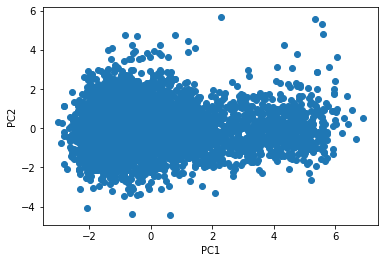

In [13]:
#PCA
pca = PCA(n_components=None)
pca.fit(X_train)
eigenvalues = pca.explained_variance_
idx = np.where(eigenvalues > 1)[0]
pca = PCA(n_components=len(idx))
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(len(idx))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_test_pca[:,0], X_test_pca[:,1])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.show()

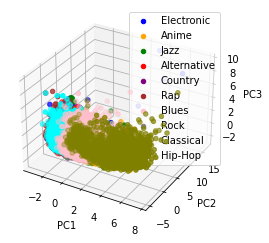

In [14]:
pca = PCA(n_components=None)
pca.fit(X_train)
eigenvalues = pca.explained_variance_
idx = np.where(eigenvalues > 1)[0]
pca = PCA(n_components=len(idx))
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for genre, color in zip(genres, colors):
    idx = np.where(y_train == label_encoder.transform([genre])[0])[0]
    ax.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], X_train_pca[idx, 2], c=color, label=genre)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()

plt.show()

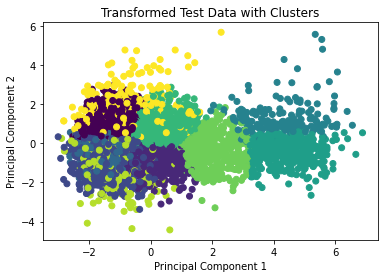

In [15]:
#Brief glance for kMeans
kmeans = KMeans(n_clusters=10, random_state=0)
y_pred = kmeans.fit_predict(X_test_pca)


plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred)
plt.title('Transformed Test Data with Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

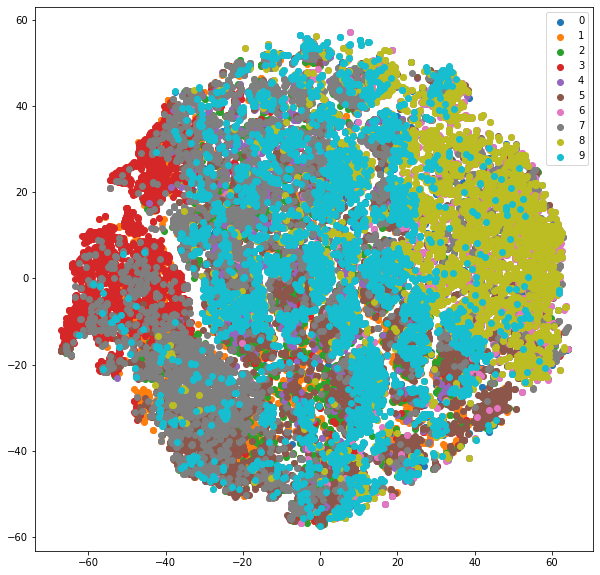

In [16]:
#t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)
plt.figure(figsize=(10, 10))
for label in np.unique(y_train):
    plt.scatter(X_train_tsne[y_train == label, 0],
                X_train_tsne[y_train == label, 1],
                label=label)
plt.legend()
plt.show()

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


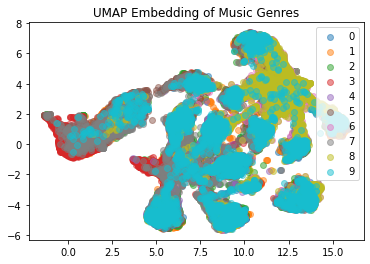

In [17]:
#UMAP
umap_reducer = umap.UMAP(n_components=2)
X_train_umap = umap_reducer.fit_transform(X_train)
for label in np.unique(y_train):
    mask = y_train == label
    plt.scatter(X_train_umap[mask, 0], X_train_umap[mask, 1], label=label, alpha=0.5)
plt.legend()
plt.title("UMAP Embedding of Music Genres")
plt.show()

In [18]:
X_test_umap = umap_reducer.transform(X_test)

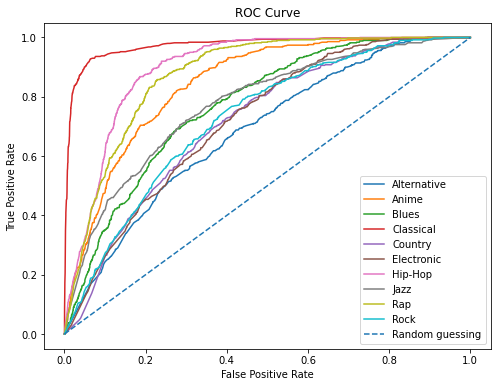

AUC scores:
Alternative: 0.683
Anime: 0.845
Blues: 0.771
Classical: 0.973
Country: 0.716
Electronic: 0.719
Hip-Hop: 0.898
Jazz: 0.774
Rap: 0.875
Rock: 0.727


In [23]:
#Time for clustering
#adaBoost and PCA
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
genres = label_encoder.inverse_transform(np.unique(y_train))
auc_scores = {}

plt.figure(figsize=(8, 6))

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)

    adaboost.fit(X_train_pca, y_train_genre)
    y_prob = adaboost.predict_proba(X_test_pca)[:, 1]
    auc_score = roc_auc_score(y_test_genre, y_prob)
    auc_scores[genre] = auc_score
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=genre)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")


In [ ]:
#SVM and PCA
svm = SVC(probability=True)
genres = label_encoder.inverse_transform(np.unique(y_train))
auc_scores = {}

plt.figure(figsize=(8, 6))

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)

    svm.fit(X_train_pca, y_train_genre)
    y_prob = svm.predict_proba(X_test_pca)[:, 1]
    auc_score = roc_auc_score(y_test_genre, y_prob)
    auc_scores[genre] = auc_score
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=genre)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")


In [ ]:
#randomForest and PCA
random_forest = RandomForestClassifier(n_estimators=100)
genres = label_encoder.inverse_transform(np.unique(y_train))
auc_scores = {}

plt.figure(figsize=(8, 6))

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)

    random_forest.fit(X_train_pca, y_train_genre)
    y_prob = random_forest.predict_proba(X_test_pca)[:, 1]
    auc_score = roc_auc_score(y_test_genre, y_prob)
    auc_scores[genre] = auc_score
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=genre)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")


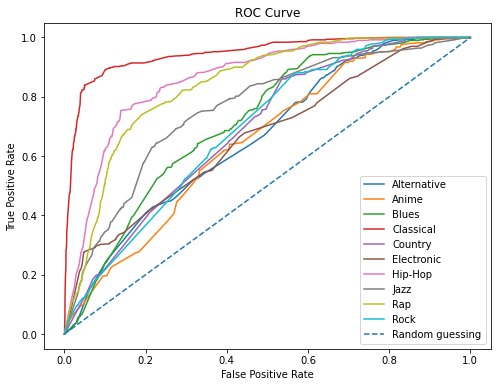

AUC scores:
Alternative: 0.663
Anime: 0.650
Blues: 0.716
Classical: 0.946
Country: 0.688
Electronic: 0.663
Hip-Hop: 0.862
Jazz: 0.758
Rap: 0.840
Rock: 0.690


In [37]:
#Seems like adaBoost performs well
#Let's try with other dimension reduction method
#UMAP? Since it preserve local structure

adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
genres = label_encoder.inverse_transform(np.unique(y_train))
auc_scores = {}

plt.figure(figsize=(8, 6))

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)

    adaboost.fit(X_train_umap, y_train_genre)
    y_prob = adaboost.predict_proba(X_test_umap)[:, 1]
    auc_score = roc_auc_score(y_test_genre, y_prob)
    auc_scores[genre] = auc_score
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=genre)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")

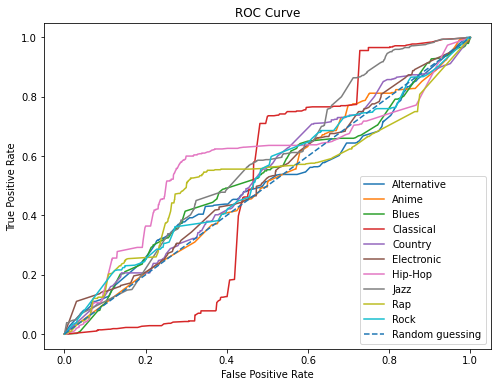

AUC scores:
Alternative: 0.507
Anime: 0.508
Blues: 0.526
Classical: 0.501
Country: 0.530
Electronic: 0.524
Hip-Hop: 0.579
Jazz: 0.574
Rap: 0.527
Rock: 0.531


In [40]:
#And t-SNE
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
genres = label_encoder.inverse_transform(np.unique(y_train))
auc_scores = {}

plt.figure(figsize=(8, 6))

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)

    adaboost.fit(X_train_tsne, y_train_genre)
    y_prob = adaboost.predict_proba(X_test_tsne)[:, 1]
    auc_score = roc_auc_score(y_test_genre, y_prob)
    auc_scores[genre] = auc_score
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=genre)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")

#NOPE.

In [19]:
#Now Arete adaBoost and SVM
pca = PCA(n_components=None)
pca.fit(X_train)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1
pca = PCA(n_components=n_components)
X_train_pca1 = pca.fit_transform(X_train)
X_test_pca1 = pca.transform(X_test)
print(n_components)

8


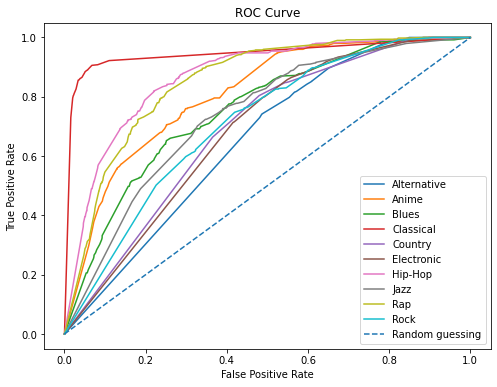

AUC scores:
Alternative: 0.654
Anime: 0.808
Blues: 0.754
Classical: 0.944
Country: 0.690
Electronic: 0.684
Hip-Hop: 0.868
Jazz: 0.735
Rap: 0.851
Rock: 0.711


In [46]:
X_test_pca1 = pca.transform(X_test)
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.01)
genres = label_encoder.inverse_transform(np.unique(y_train))
auc_scores = {}

plt.figure(figsize=(8, 6))

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)

    adaboost.fit(X_train_pca1, y_train_genre)
    y_prob = adaboost.predict_proba(X_test_pca1)[:, 1]
    auc_score = roc_auc_score(y_test_genre, y_prob)
    auc_scores[genre] = auc_score
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=genre)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")


In [47]:
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 1.0]}

grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5, scoring='roc_auc')

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)
    grid_search.fit(X_train_pca1, y_train_genre)
    print(f"Best hyperparameters for {genre}: {grid_search.best_params_}")


Best hyperparameters for Alternative: {'learning_rate': 1.0, 'n_estimators': 200}
Best hyperparameters for Anime: {'learning_rate': 0.1, 'n_estimators': 200}
Best hyperparameters for Blues: {'learning_rate': 1.0, 'n_estimators': 100}
Best hyperparameters for Classical: {'learning_rate': 0.1, 'n_estimators': 100}
Best hyperparameters for Country: {'learning_rate': 1.0, 'n_estimators': 200}
Best hyperparameters for Electronic: {'learning_rate': 1.0, 'n_estimators': 200}
Best hyperparameters for Hip-Hop: {'learning_rate': 0.1, 'n_estimators': 200}
Best hyperparameters for Jazz: {'learning_rate': 1.0, 'n_estimators': 200}
Best hyperparameters for Rap: {'learning_rate': 0.1, 'n_estimators': 200}
Best hyperparameters for Rock: {'learning_rate': 1.0, 'n_estimators': 200}


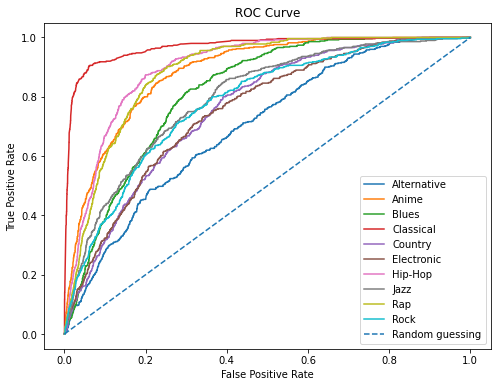

AUC scores:
Alternative: 0.699
Anime: 0.884
Blues: 0.816
Classical: 0.968
Country: 0.760
Electronic: 0.754
Hip-Hop: 0.898
Jazz: 0.796
Rap: 0.885
Rock: 0.780


In [48]:
best_hyperparams = {
    'Alternative': {'n_estimators': 200, 'learning_rate': 1.0},
    'Anime': {'n_estimators': 200, 'learning_rate': 0.1},
    'Blues': {'n_estimators': 100, 'learning_rate': 1.0},
    'Classical': {'n_estimators': 100, 'learning_rate': 0.1},
    'Country': {'n_estimators': 200, 'learning_rate': 1.0},
    'Electronic': {'n_estimators': 200, 'learning_rate': 1.0},
    'Hip-Hop': {'n_estimators': 200, 'learning_rate': 0.1},
    'Jazz': {'n_estimators': 200, 'learning_rate': 1.0},
    'Rap': {'n_estimators': 200, 'learning_rate': 0.1},
    'Rock': {'n_estimators': 200, 'learning_rate': 1.0}
}

plt.figure(figsize=(8, 6))

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)

    adaboost = AdaBoostClassifier(n_estimators=best_hyperparams[genre]['n_estimators'], 
                                   learning_rate=best_hyperparams[genre]['learning_rate'])
    adaboost.fit(X_train_pca1, y_train_genre)
    y_prob = adaboost.predict_proba(X_test_pca1)[:, 1]
    auc_score = roc_auc_score(y_test_genre, y_prob)
    auc_scores[genre] = auc_score
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=genre)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")


In [ ]:
#Random Forest perform better than adaboost.
#How I would want to run, for classification
#But did not manage to due to computer incompetence
#Using grid search to find the optimal hyperparameters

param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

best_hyperparams = {}

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)

    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train_pca1, y_train_genre)

    best_hyperparams[genre] = grid_search.best_params_
    print(f"Best hyperparameters for {genre}: {best_hyperparams[genre]}")

    random_forest = RandomForestClassifier(n_estimators=best_hyperparams[genre]['n_estimators'],
                                            max_depth=best_hyperparams[genre]['max_depth'],
                                            min_samples_split=best_hyperparams[genre]['min_samples_split'],
                                            min_samples_leaf=best_hyperparams[genre]['min_samples_leaf'])
    random_forest.fit(X_train_pca1, y_train_genre)

    y_prob = random_forest.predict_proba(X_test_pca1)[:, 1]
    auc_score = roc_auc_score(y_test_genre, y_prob)
    auc_scores[genre] = auc_score
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=genre)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")


# The Result

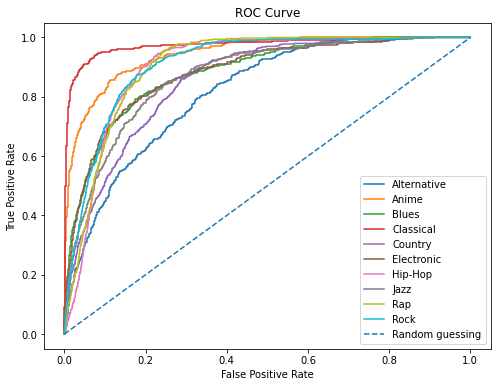

AUC scores:
Alternative: 0.813
Anime: 0.945
Blues: 0.883
Classical: 0.975
Country: 0.856
Electronic: 0.882
Hip-Hop: 0.904
Jazz: 0.870
Rap: 0.907
Rock: 0.912


In [20]:
#So I resigned to choosing resonable hyperparameters and run the model manually 
#Which indeed led to the optimal result so far.
random_forest = RandomForestClassifier(n_estimators = 100,
                                        max_depth = 10,
                                        min_samples_split = 2,
                                        min_samples_leaf = 1)
genres = label_encoder.inverse_transform(np.unique(y_train))
auc_scores = {}

plt.figure(figsize=(8, 6))

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)

    random_forest.fit(X_train_pca1, y_train_genre)
    y_prob = random_forest.predict_proba(X_test_pca1)[:, 1]
    auc_score = roc_auc_score(y_test_genre, y_prob)
    auc_scores[genre] = auc_score
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=genre)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")


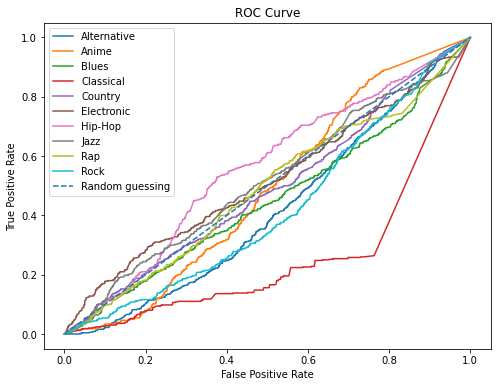

AUC scores:
Alternative: 0.417
Anime: 0.487
Blues: 0.451
Classical: 0.253
Country: 0.490
Electronic: 0.517
Hip-Hop: 0.557
Jazz: 0.512
Rap: 0.487
Rock: 0.419


In [21]:
#Just checking for different dimension reduction method
#Just in case
random_forest = RandomForestClassifier(n_estimators = 100,
                                        max_depth = 20,
                                        min_samples_split = 2,
                                        min_samples_leaf = 1)
genres = label_encoder.inverse_transform(np.unique(y_train))
auc_scores = {}

plt.figure(figsize=(8, 6))

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)

    random_forest.fit(X_train_tsne, y_train_genre)
    y_prob = random_forest.predict_proba(X_test_tsne)[:, 1]
    auc_score = roc_auc_score(y_test_genre, y_prob)
    auc_scores[genre] = auc_score
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=genre)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")


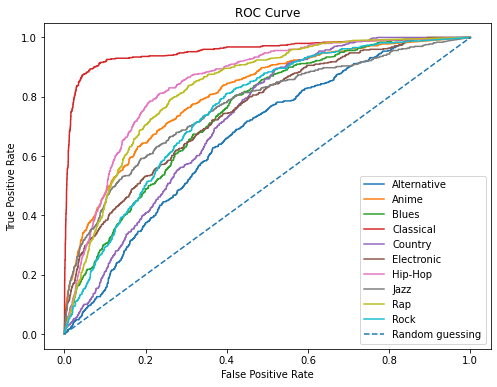

AUC scores:
Alternative: 0.666
Anime: 0.807
Blues: 0.745
Classical: 0.955
Country: 0.721
Electronic: 0.751
Hip-Hop: 0.846
Jazz: 0.765
Rap: 0.828
Rock: 0.755


In [22]:
#UMAP
random_forest = RandomForestClassifier(n_estimators = 100,
                                        max_depth = 20,
                                        min_samples_split = 2,
                                        min_samples_leaf = 1)
genres = label_encoder.inverse_transform(np.unique(y_train))
auc_scores = {}

plt.figure(figsize=(8, 6))

for genre in genres:
    y_train_genre = np.where(y_train == label_encoder.transform([genre])[0], 1, 0)
    y_test_genre = np.where(y_test == label_encoder.transform([genre])[0], 1, 0)

    random_forest.fit(X_train_umap, y_train_genre)
    y_prob = random_forest.predict_proba(X_test_umap)[:, 1]
    auc_score = roc_auc_score(y_test_genre, y_prob)
    auc_scores[genre] = auc_score
    fpr, tpr, _ = roc_curve(y_test_genre, y_prob)
    plt.plot(fpr, tpr, label=genre)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC scores:")
for genre in genres:
    print(f"{genre}: {auc_scores[genre]:.3f}")
